# MODFLOW 6: modelo GWF.


## Resumen.
En este documento se realiza una simulación de flujo en dos dimensiones explicando paso a paso el proceso y describiendo los paquetes del modelo GWF que son usados. Se utilizan las herramientas de flopy para facilitar el pre y postprocesamiento de la información requerida por el simulador.

<p xmlns:cc="http://creativecommons.org/ns#" xmlns:dct="http://purl.org/dc/terms/"><a property="dct:title" rel="cc:attributionURL" href="https://github.com/luiggix/RTWMA/">MODFLOW 6: modelo GWF</a> by <b>Luis M. de la Cruz Salas (2025)</b> is licensed under <a href="http://creativecommons.org/licenses/by-sa/4.0/?ref=chooser-v1" target="_blank" rel="license noopener noreferrer" style="display:inline-block;">Attribution-ShareAlike 4.0 International<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a>.</p> 

# Introducción.

El modelo GWF (*Groundwater Flow*) de MODFLOW 6 es un componente principal que simula el flujo del agua subterránea en medios porosos, como acuíferos. 

Este modelo resuelve la ecuación de flujo en tres dimensiones, permitiendo representar cómo el agua se mueve bajo tierra en función de las propiedades del subsuelo, las condiciones de frontera y las fuentes o sumideros, como recarga, pozos y ríos. 

El modelo GWF se define dentro de una simulación general y puede conectarse con otros modelos, como el de transporte de solutos (GWT) o modelos de flujo de superficie. Esto permite construir simulaciones integradas con diferentes procesos acoplados.

Un modelo GWF puede ser configurado por varios paquetes. Un paquete es la parte del modelo que se ocupa de un único aspecto de la simulación. 

<div class="alert alert-block alert-info">

# Ejemplo: Simulación de flujo en 2D.

En este ejemplo se simula una distribución de carga hidráulica en un dominio rectangular de $15$ m $\times$ $10$ m con una sola capa con espesor de $1$ m.  La carga va de $10$ m en el lado izquierdo a $5$ m en lado derecho, formando un gradiente horizontal de flujo. Los lados superior e inferior del dominio son impermeables. No hay fuentes ni sumideros. El valor de la conductividad hidráulica es constante $k = 1.0$.

</div>

## Paso 1. Configuración inicial.

* Haremos la configuración inicial de la simulación de manera similar al ejemplo de la notebook [01_MF6_GWF_init.ipynb](01_MF6_GWF_init.ipynb). 
* En este caso agregaremos algunas opciones adicionales al solucionador IMS para ver el efecto que tiene en los archivos de entrada, particularmente en `flow.ims`, véase **Iterative Model Solution**, pp 225-231, en [2]. 
* El espacio de trabajo donde se escriben todos los archivos será la carpeta `sandbox2`.
* La simulación así como el modelo de flujo tendrán el nombre `flow`.
* Todo lo anterior se realiza en la siguiente celda de código:


In [1]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import os

# Biblioteca con algunas herramientas adicionales que se puede instalar como sigue:
#pip install git+https://github.com/luiggix/xmf6
import xmf6 

# --- Ruta a los ejecutables de MODFLOW 6. Opciones de SO's: linux, macos, macosarm, windows
exe_name = "C:\\Users\\luiggi\\Documents\\GitSites\\xmf6\\mf6\\windows\\mf6"
#exe_name = "../../../mf6/macosarm/mf6"

# --- Configuración inicial ---
sim_name = "flow"
sim_ws = "sandbox2"

o_sim = flopy.mf6.MFSimulation(
    sim_name = sim_name,
    exe_name = exe_name,
    sim_ws   = sim_ws
)

# --- Tiempos de simulación ---
o_tdis = flopy.mf6.ModflowTdis(
    simulation = o_sim,
    time_units = "DAYS",
    nper = 1,
    perioddata = [(1.0, 1, 1.0)],
)

# --- Solucionador numérico (IMS) ---
o_ims = flopy.mf6.ModflowIms(
    simulation          = o_sim,
    print_option        = "SUMMARY",
    complexity          = "SIMPLE",
    outer_dvclose       = 1e-4,
    outer_maximum       = 50,
    under_relaxation    = "NONE",
    linear_acceleration = "CG",
    inner_maximum       = 30,
    inner_dvclose       = 1e-6,
)

# --- Modelo GWF ---
o_gwf = flopy.mf6.ModflowGwf(
    simulation = o_sim,
    modelname = sim_name,
    model_nam_file = f"{sim_name}.nam",
    save_flows = True # Almacena los flujos, particularmente el budget
)

# --- Escribimos los archivos ---
o_sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...


<div class="alert alert-block alert-info">

**Observación.**

Revisa los archivos generados en la carpeta `sandbox2`, particularmente el archivo `flow.ims`.

</div>

## Paquetes.

Para generar esta simulación se requiere de agregar paquetes al modelo GWF como se muestra en la siguiente figura, tomada de [1]:

<img src="../figures/gwf_mf6.png" width=450px hspace="5" vspace="5"/>

## Paso 2. Discretización espacial.

El dominio espacial de una simulación en MODFLOW 6 se divide en una rejilla de celdas y provee de  tres paquetes diferentes (véase **Chapter 3. Spatial Discretization** en [1]):

* **DIS**. Paquete para discretización estructurada.
* **DISV**. Paquete para discretización por vértices.
* **DISU**. Paquete para discretización NO estructurada.

Solo se puede usar uno de los paquetes de discretización en una simulación con GWF.

La información almacenada en los paquetes de discretización es usada durante la simulación por GWF para realizar varias acciones, por ejemplo:
* calcular la conductividad hidráulica entre celdas conectadas, 
* calcular los volúmenes de celda para los cálculos de almacenamiento,
* convertir los flujos de recarga y evapotranspiración, por ejemplo de las dimensiones de L/T a L$^3$/T.

Los paquetes de discretización:
* contienen información acerca de las celdas, como las elevaciones superior (`TOP`) e inferior (`BOTTOM`) de la celda y las dimensiones o áreas de la celda (en vista de planta). 
* definen la conectividad de las celdas para describir cómo están conectadas entre sí las celdas del modelo y las propiedades geométricas de las conexiones.
* En el paquete **DIS**, la conectividad de la celda se describe implícitamente por la estructura de la malla, las dimensiones de la celda en las direcciones de renglones y columnas, y las elevaciones de la parte superior e inferior de la celda.

La siguiente figura, tomada de [1], muestra un ejemplo de una malla regular en tres dimensiones en donde se definen columnas, renglones y capas.

<img src="../figures/mesh_3D_mf6.png" width=400px hspace="5" vspace="5" style="float: left;"/>

* En este ejemplo tenemos 9 columnas (`NROW`), 5 renglones (`NCOL`) y 5 capas (`NLAY`).

* El tamaño horizontal de las celdas está definido por $\Delta r_i$ y $\Delta c_i$ (variables `DELR`$_i$ y  `DELC`$_i$). 

* Observa que $\Delta r_i$ se mide en la dirección de los renglones (en el eje $x$ en un sistema Cartesiano), es decir, mide el tamaño de la columna $i$-ésima. 

* Por otro lado, $\Delta c_i$ se mide en la dirección de las columnas (en el eje $y$), por lo que mide el tamaño del renglón $i$-ésimo

* Las capas se numeran empezando por la capa superior y hacia abajo. 

* Las elevaciones de las celdas se especifican en la variable `BOTM` (indica la parte inferior de cada capa).

* La elevación de la parte superior de la primera capa se debe especificar en la variable `TOP`.

* La información de las elevaciones se usa para calcular el espesor de las celdas.


<div class="alert alert-block alert-info">

**Parámetros a usar**.

* Para obtener el modelo del dominio rectangular requerido, una capa de $15$ m $\times$ $10$ m con un espesor de $1$ m, usaremos los parámetros `nrow`, `ncol`, `nlay`, `delr` y `delc`.
* Para obtener la longitud correcta del dominio se debe cumplir que:
    *  `nrow` * `delc` $ = 15$,
    *  `ncol` * `delr` $ = 10$.
* Los parámetros `top` y `botm` deben ser tales que `top - botm` $= 1$.
* En la siguiente celda se definen estos parámetros para generar la malla del dominio:

</div>

In [2]:
# --- Discretización espacial ---
nlay = 1
nrow = 10
ncol = 15
delr = 1.0
delc = 1.0
top  = 0.0
botm = -1.0

o_dis = flopy.mf6.ModflowGwfdis(
    model = o_gwf,
    length_units = "METERS",
    nlay = nlay,
    nrow = nrow,
    ncol = ncol,
    delr = delr,
    delc = delc,
    top  = top,
    botm = botm,
)

print(o_dis)
o_sim.write_simulation()

package_name = dis
filename = flow.dis
package_type = dis
model_or_simulation_package = model
model_name = flow

Block options
--------------------
length_units
{internal}
(meters)


Block dimensions
--------------------
nlay
{internal}
(1)

nrow
{internal}
(10)

ncol
{internal}
(15)


Block griddata
--------------------
delr
{constant 1.0}

delc
{constant 1.0}

top
{constant 0.0}

botm
{constant -1.0}



writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...


<div class="alert alert-block alert-info">

**Explicación**.

* En la celda anterior se construye el objeto `o_dis` de la clase [`flopy.mf6.ModflowGwfdis`](https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfgwfdis.html) para generar la información de la discretización espacial. Esta clase construye una discretiación de tipo DIS.
* El primer parámetro en esta construcción es el objeto del modelo al que esta discretización pertenece, en este caso `o_gwf`. Posteriormente se agregan todos los parámetros de la discretización.
* La celda anterior genera el archivo `flow.dis` con la información correspondiente a la discretización espacial, revisa este archivo en la carpeta `sandbox2`.
* Adicionalmente, el archivo `flow.nam` es modificado agregando la información del paquete DIS, deberías ver un bloque como el siguiente en ese archivo:

```
BEGIN packages
  DIS6  flow.dis  dis
END packages
```
</div>

Flopy contiene herramientas para obtener la información de la discretización espacial y hacer una gráfica del dominio. Por ejemplo:

* `o_gwf.modelgrid`: regresa un objeto que contiene toda la información de la discretización.
* `o_gwf.modelgrid.extent`: extensión del dominio (xmin, xmax, ymin, ymax).
* `o_gwf.modelgrid.nrow`: número de renglones.
* `o_gwf.modelgrid.ncol`: número de columnas.
* `o_gwf.modelgrid.nlay`: número de capas.
* `o_gwf.modelgrid.delr`: tamaño de las celdas en dirección de los renglones (coord. $x$, tamaño de las columas).
* `o_gwf.modelgrid.delc`: tamaño de las celdas en dirección de las columnas (coord. $y$, tamaño de los renglones).
* `o_gwf.modelgrid.delz`: tamaño de las celdas en dirección vertical (coord. $z$, tamaño de las capas).
* `o_gwf.modelgrid.top`: parte superior de la primera capa.
* `o_gwf.modelgrid.botm`: parte inferior de todas las celdas.
* `o_gwf.modelgrid.xyzcellcenters`: centros de las celdas de la malla

Veamos como podemos obtener y usar esta información.

In [3]:
# Obtenemos el objeto con la información de la discretización espacial
grid = o_gwf.modelgrid

grid.extent
print("Extensión del dominio (xmin, xmax, ymin, ymax)")
print(grid.extent[0], grid.extent[1], grid.extent[2], grid.extent[3])

print("\nNúmero de renglones, columnas y capas")
print(grid.nrow, grid.ncol, grid.nlay)

Extensión del dominio (xmin, xmax, ymin, ymax)
0.0 15.0 0.0 10.0

Número de renglones, columnas y capas
10 15 1


In [4]:
print(len(grid.delr), grid.delr)
# grid.delr es un numpy.ndarray 1D de tamaño ncol
# grid.delc es un numpy.ndarray 1D de tamaño nrow
# grid.delz es un numpy.ndarray 3D de tamaño nlay x ncol x nrow
# Usamos la función xmf6.info_array() para imprimir las propiedades de arreglos de numpy
print("\ngrid.delr =", grid.delr[0])
xmf6.info_array(grid.delr)
print("\ngrid.delc =", grid.delc[0])
xmf6.info_array(grid.delc)
print("\ngrid.delz =", grid.delz[0][0][0])
xmf6.info_array(grid.delz)

15 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

grid.delr = 1.0
 tipo  : <class 'numpy.ndarray'> 
 dtype : float64 
 dim   : 1 
 shape : (15,) 
 size(bytes) : 8 
 size(elements) : 15

grid.delc = 1.0
 tipo  : <class 'numpy.ndarray'> 
 dtype : float64 
 dim   : 1 
 shape : (10,) 
 size(bytes) : 8 
 size(elements) : 10

grid.delz = 1.0
 tipo  : <class 'numpy.ndarray'> 
 dtype : float64 
 dim   : 3 
 shape : (1, 10, 15) 
 size(bytes) : 8 
 size(elements) : 150


In [5]:
# grid.top es un numpy.ndarray 2D de tamaño nrow x ncol
# grid.botm es un numpy.ndarray 3D de tamaño nlay x nrow x ncol
print("grid.top =", grid.top[0][0])
xmf6.info_array(grid.top)
print("\ngrid.botm =", grid.botm[0][0][0])
xmf6.info_array(grid.botm)

grid.top = 0.0
 tipo  : <class 'numpy.ndarray'> 
 dtype : float64 
 dim   : 2 
 shape : (10, 15) 
 size(bytes) : 8 
 size(elements) : 150

grid.botm = -1.0
 tipo  : <class 'numpy.ndarray'> 
 dtype : float64 
 dim   : 3 
 shape : (1, 10, 15) 
 size(bytes) : 8 
 size(elements) : 150


In [6]:
# Dos maneras de calcular la longitud del dominio en las direcciones de los ejes son:
print("(1) Lx = ", grid.extent[1] - grid.extent[0])
print("    Ly = ", grid.extent[3] - grid.extent[2])
print("(2) Lx = ", grid.ncol * grid.delr[0])
print("    Ly = ", grid.nrow * grid.delc[0])

(1) Lx =  15.0
    Ly =  10.0
(2) Lx =  15.0
    Ly =  10.0


In [7]:
# grid.xyzcellcenters es una lista que contiene un numpy.ndarray de nrow x ncol
print("grid.xyzcellcenters[0]")
xmf6.info_array(grid.xyzcellcenters[0])

grid.xyzcellcenters[0]
 tipo  : <class 'numpy.ndarray'> 
 dtype : float64 
 dim   : 2 
 shape : (10, 15) 
 size(bytes) : 8 
 size(elements) : 150


Flopy contiene herramientas para visualización. Por ejemplo podemos crear un objeto de la clase `flopy.plot.PlotMapView` para graficar la malla:

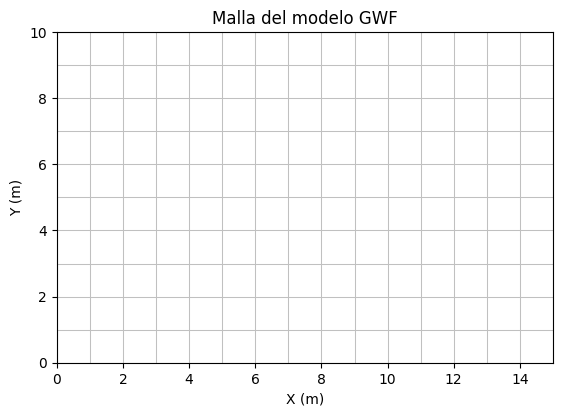

In [8]:
# Crear objeto de vista en planta
mapview = flopy.plot.PlotMapView(model=o_gwf)

# Dibujar la malla
mapview.plot_grid(linewidths=0.75, color="silver")

plt.title("Malla del modelo GWF")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.gca().set_aspect('equal')  # Para mantener proporciones
plt.show()

## Paso 3. Condiciones iniciales.

El paquete encargado de definir las condiciones iniciales es IC (*Initial Conditions*). Véase **Initial Conditions (IC) Package**, pp 43 en [2], para más información.

Se utiliza para asignar los valores iniciales de la carga hidráulica en todas las celdas activas del modelo al comenzar una simulación, especialmente importante cuando se trabaja con modelos transitorios. 

Se aplica al inicio del primer periodo de estrés y es obligatorio en el modelo GWF.

En simulaciones estacionarias, los valores iniciales no afectan los resultados finales, pero aún así son requeridos por MODFLOW 6. 

El modelo no podrá ejecutarse correctamente si no se proporciona este paquete.

<div class="alert alert-block alert-info">

**Parámetros a usar**.

* Usaremos la clase [`flopy.mf6.ModflowGwfic`](https://flopy.readthedocs.io/en/latest/source/flopy.mf6.modflow.mfgwfic.html) para crear el objeto `o_ic`. 
* El primer parámetro es el modelo `o_gwf` al que se le desean agregar las condiciones iniciales.
* El parámetro `strt` indica el valor de la condición inicial para la carga hidráulica. Puede ser un número escalar (mismo valor en todo el dominio) o un arreglo 2D o 3D para especificar la carga en cada celda.

En la siguiente celda se genera una condición inicial de carga hidráulica igual a $10$:

</div>

In [9]:
o_ic = flopy.mf6.ModflowGwfic(
    model = o_gwf,
    strt=10.0 
)

print(o_ic)
o_sim.write_simulation()

package_name = ic
filename = flow.ic
package_type = ic
model_or_simulation_package = model
model_name = flow

Block griddata
--------------------
strt
{constant 10.0}



writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package ic...


<div class="alert alert-block alert-info">

**Explicación**.

* La celda anterior genera el archivo `flow.ic` con la información para las condiciones iniciales.
* Adicionalmente se agrega la información de este paquete en el archivo `flow.nam`. Deberías obtener un bloque en ese archivo como el que sigue: 

```
BEGIN packages
  DIS6  flow.dis  dis
  IC6  flow.ic  ic
END packages
```

<br>

**TIP**. Si se tiene un modelo con topografía variable y se desea usar la elevación superior como condición inicial, se podría hacer algo como:

```python
strt = top.copy()  # usar la elevación como nivel inicial
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)
```
</div>

## Paso 4. Condiciones de frontera.

EL paquete CHD tienen un funcionamiento diferente al de los otros paquetes hidrológicos de MODFLOW 6; no adiciona cambios en el sistema de ecuaciones como lo hacen otros paquetes. Lo que hace CHD es simplemente asignar un código interno indicando que:

1. la carga varía con el tiempo (celda con carga variable),
2. la carga es constante (celda con carga constante),
3. no hay flujo hacia dentro o hacia afuera de la celda (celda inactiva).

Este código es usado por la componente de solución numérica para determinar cómo debe manejar las ecuaciones.

El paquete CHD lee los datos del archivo con extensión `.chd` en donde se indica la lista de celdas con el valor correspondiente y lee la información al inicio de cada periodo de estrés, lo que hace posible cambiar el valor de la carga en dichas celdas durante la simulación.

Con este paquete se pueden imponer condiciones de frontera de tipo Dirichlet para la carga hidráulica. 

Véase **Constant-Head (CHD) Package**, pp 76 en [2], para más información.



<div class="alert alert-block alert-info">

**Preparación de los datos**.

* Para definir las condiciones $h = 10$ en $x=0$ y $h = 5$ en $x=15$, primero crearemos una lista de índices y valores como sigue:
</div>

In [10]:
chd_data = []
for row in range(nrow):
    chd_data.append([(0, row, 0), 10.0])       # Condición en la pared izquierda
    chd_data.append([(0, row, ncol - 1), 5.0]) # Condición en la pared derecha

# Revisamos el resultado
for c in chd_data:
    print(c)

[(0, 0, 0), 10.0]
[(0, 0, 14), 5.0]
[(0, 1, 0), 10.0]
[(0, 1, 14), 5.0]
[(0, 2, 0), 10.0]
[(0, 2, 14), 5.0]
[(0, 3, 0), 10.0]
[(0, 3, 14), 5.0]
[(0, 4, 0), 10.0]
[(0, 4, 14), 5.0]
[(0, 5, 0), 10.0]
[(0, 5, 14), 5.0]
[(0, 6, 0), 10.0]
[(0, 6, 14), 5.0]
[(0, 7, 0), 10.0]
[(0, 7, 14), 5.0]
[(0, 8, 0), 10.0]
[(0, 8, 14), 5.0]
[(0, 9, 0), 10.0]
[(0, 9, 14), 5.0]


<div class="alert alert-block alert-info">

**Parámetros a usar**.

* Ahora creamos un objeto de la clase [`flopy.mf6.ModflowGwfchd`](https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfgwfchd.html).
* El primer parámetro será el modelo `o_gwf` al que se le impondrán las condiciones iniciales.
* En este ejemplo usamos el parámetro `stress_period_data` para definir las condiciones de frontera, que requiere una lista de la forma: `[cellid, head, aux, boundname]` donde:
    - `cellid` es el identificador de la celda.
        - Para una malla de tipo DIS el CELLID está formado por tuplas (layer, row, column).
        - Se usan arreglos que inician en $0$.
        - Flopy ajustará el valor de los índices para ejecutar MODFLOW 6 en donde los índices inician en $1$.
    - `head` es el valor de la carga hidráulica en la frontera.
    - los valores `aux` y `boundname` son opcionales y no se usarán por ahora.

* La lista `chd_data` creada anteriormente se usará como argumento de `stress_period_data`, veamos como:

</div>

In [11]:
o_chd = flopy.mf6.ModflowGwfchd(
    model = o_gwf,
    stress_period_data=chd_data,
)

print(o_chd)
o_sim.write_simulation()

package_name = chd_0
filename = flow.chd
package_type = chd
model_or_simulation_package = model
model_name = flow

Block period
--------------------
stress_period_data
{internal}
(    cellid_layer  cellid_row  cellid_column  head
0              0           0              0  10.0
1              0           0             14   5.0
2              0           1              0  10.0
3              0           1             14   5.0
4              0           2              0  10.0
5              0           2             14   5.0
6              0           3              0  10.0
7              0           3             14   5.0
8              0           4              0  10.0
9              0           4             14   5.0
10             0           5              0  10.0
11             0           5             14   5.0
12             0           6              0  10.0
13             0           6             14   5.0
14             0           7              0  10.0
15             0    

<div class="alert alert-block alert-info">

**Observación**.

El resultado se escribirá en el archivo  `flow.chd` que contendrá la lista de celdas con el valor correspondiente. 
</div>

## Paso 5. Propiedades hidráulicas.

El paquete NPF (*Node Property Flow*) calcula la conductancia hidráulica, tanto vertical como horizontal, entre celdas adyancentes.

Este paquete calcula los coeficientes $C_{n,m}$ que aparecen en la siguiente forma de la ecuación CVFD:

$$
\sum_{m \in \eta_n} C_{n,m}(h_m - h_n) - P_n h_n + Q_n = SS_n A_n \Delta v_n \dfrac{h_n - HOLD_n}{t -t_{old}}
$$

NPF soporta celdas confinadas y convertibles. Para determinar el tipo de celda se usa el parámetro *ICELLTYPE*.

También, usando NPF se define la conductividad hidráulica $k$.

Para más información véase [1] **Chapter 4. Internal Flow Packages**, pp 4-1, y **Node Property Flow (NPF) Package**, pp 49 en [2].

<div class="alert alert-block alert-info">

**Parámetros a usar**.

* En este caso la conductividad hidráulica es constante $k = 1.0$. 
* Usamos un objeto de la clase [`flopy.mf6.ModflowGwfnpf`](https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfgwfnpf.html) para definir el valor de $k$.
* También agregamos el parámetro `save_specific_discharge = True` para almacenar la descarga específica $q$.

</div>

In [12]:
o_npf = flopy.mf6.ModflowGwfnpf(
    model = o_gwf,
    save_specific_discharge = True,
    k = 1.0, # conductividad hidráulica (constante)
)

print(o_npf)
o_sim.write_simulation()

package_name = npf
filename = flow.npf
package_type = npf
model_or_simulation_package = model
model_name = flow

Block options
--------------------
save_specific_discharge
{internal}
(True)


Block griddata
--------------------
icelltype
{constant 0}

k
{constant 1.0}



writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package chd_0...
    writing package npf...


<div class="alert alert-block alert-info">

**Observación**.

El código anterior genera el archivo `flow.npf` con el siguiente contenido:

```
# File generated by Flopy version 3.9.2 on 04/26/2025 at 11:32:43.
BEGIN options
  SAVE_SPECIFIC_DISCHARGE
END options

BEGIN griddata
  icelltype
    CONSTANT  0
  k
    CONSTANT       1.00000000
END griddata
```

</div>

## Paso 6. Configuración de la salida.

EL paquete OC (*Output Control*) determina cómo y cuándo se imprimirá o almacenará la información de salida de la simulación carga hidráulica (head) y del *budget*.

Esta información se puede enviar a:
* la pantalla de salida cuando se ejectua MODFLOW 6,
* los archivos de listado `.lst`,
* archivos en formato binario.

Para más información véase **Output Control (OC) Option**, pp 44 en [2].

<div class="alert alert-block alert-info">

**Parámetros a usar**.

* Para configurar la salida usamos un objeto de la clase [`flopy.mf6.ModflowGwfoc`](https://flopy.readthedocs.io/en/3.9.0/source/flopy.mf6.modflow.mfgwfoc.html) indicando:
    - El modelo GWF,
    - los archivos para almacenar el *budget* (`flow.bud`) y la carga hidráulica (`flow.hds`),
    - la información que se almacenará en archivos binarios usando el parámetro `saverecord`,
    - la información que se enviará al archivo de listado (`flow.lst`) usando el parámetro `printrecord`.
</div>

In [13]:
o_oc = flopy.mf6.ModflowGwfoc(
    model = o_gwf,
    budget_filerecord = f"{sim_name}.bud",
    head_filerecord = f"{sim_name}.hds",
    saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord = [("HEAD", "ALL")]
)

print(o_oc)
o_sim.write_simulation()

package_name = oc
filename = flow.oc
package_type = oc
model_or_simulation_package = model
model_name = flow

Block options
--------------------
budget_filerecord
{internal}
([('flow.bud',)])

head_filerecord
{internal}
([('flow.hds',)])


Block period
--------------------
saverecord
{internal}
([('HEAD', 'ALL', None) ('BUDGET', 'ALL', None)])

printrecord
{internal}
([('HEAD', 'ALL', None)])



writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package chd_0...
    writing package npf...
    writing package oc...


<div class="alert alert-block alert-info">

**Observación**.

La celda anterior genera el archivo `flow.oc` con los datos para la salida como sigue:

```
# File generated by Flopy version 3.9.2 on 04/26/2025 at 11:36:03.
BEGIN options
  BUDGET  FILEOUT  flow.bud
  HEAD  FILEOUT  flow.hds
END options

BEGIN period  1
  SAVE  HEAD  ALL
  SAVE  BUDGET  ALL
  PRINT  HEAD  ALL
END period  1
```

</div>

## Paso 7. Ejecución de la simulación.

En este punto tenemos con toda la información de entrada en los siguientes archivos:

* `flow.tdis`: datos para la discretización temporal.
* `flow.ims`: datos para la solución numérica.
* `flow.dis`: datos para la discretización espacial.
* `flow.ic`: datos para las condiciones iniciales.
* `flow.chd`: datos para las condiciones de frontera.
* `flow.npf`: datos para los flujos entre celdas.
* `flow.oc`: datos para la salida de los resultados.
* `flow.nam`: datos para el modelo GWF, informa de los paquetes que se usan.
* `mfsim.nam`: datos de la simulación completa, informa de las componentes que se usan.

Podemos ejecutar la simulación como sigue:


In [14]:
o_sim.run_simulation(silent=False)

FloPy is using the following executable to run the model: ..\..\..\..\mf6\windows\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 10 2025 17:37:25 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Go

(True, [])

<div class="alert alert-block alert-info">

**Observaciones**.

La ejecución de la simulación genera los siguientes archivos:

* `flow.dis.grb`: información de la malla con todos los datos de las coordenadas, conectividad y otros (binario).
* `flow.bud`: datos del *budget* (binario).
* `flow.hds`: datos de la carga hidráulica (binario).
* `flow.lst`: archivo de listado con información de los resultados del modelo GWF.
* `mfsim.lst`: archivo de listado con información general de la simulación.

</div>

## Paso 8. Recuperación y visualización de los resultados.

### Recuperación de la carga hidráulica.

Para analizar los resultados generados por la simulación almacenados en los archivos descritos antes usaremos las herramientas que ofrece Flopy.

<div class="alert alert-block alert-info">

**Objetos, funciones y archivos a usar**.

* Primero recuperamos la carga hidráulica almacenada en el archivo `flow.hds` usando un objeto de la clase [`flopy.utils.HeadFile`](https://flopy.readthedocs.io/en/3.3.2/source/flopy.utils.binaryfile.html#flopy.utils.binaryfile.HeadFile).
* Posteriormente, con la función `get_data` obtenemos un arreglo de numpy con la información correspondiente:

</div>

In [15]:
# construimos el nombre con la ruta y extensión correcta
headfile = os.path.join(f"{sim_ws}", f"{sim_name}.hds")

# Objeto para obtener y manipular arreglos o series de tiempo de arreglos con datos
# de una o más celdas con información del archivo binario de la carga hidráulica.
hds = flopy.utils.HeadFile(headfile)

# Solo se obtiene la capa 0, cuando no se pone ningún valor en el parámetro mlay se obtienen todas las capas
head = hds.get_data(mflay=0)

# Imprimimos la información
print("head array")
xmf6.info_array(head)
print("\nHEAD:\n", head)

head array
 tipo  : <class 'numpy.ndarray'> 
 dtype : float64 
 dim   : 2 
 shape : (10, 15) 
 size(bytes) : 8 
 size(elements) : 150

HEAD:
 [[10.          9.64285714  9.28571428  8.92857142  8.57142856  8.21428571
   7.85714285  7.5         7.14285714  6.78571427  6.42857141  6.07142855
   5.71428569  5.35714284  5.        ]
 [10.          9.64285714  9.28571428  8.92857142  8.57142856  8.2142857
   7.85714286  7.50000001  7.14285715  6.78571428  6.42857141  6.07142855
   5.71428569  5.35714285  5.        ]
 [10.          9.64285714  9.28571428  8.92857143  8.57142857  8.21428571
   7.85714285  7.5         7.14285715  6.78571428  6.42857142  6.07142856
   5.71428571  5.35714286  5.        ]
 [10.          9.64285714  9.28571429  8.92857143  8.57142858  8.21428572
   7.85714286  7.5         7.14285715  6.78571429  6.42857143  6.07142858
   5.71428572  5.35714286  5.        ]
 [10.          9.64285715  9.28571429  8.92857143  8.57142858  8.21428572
   7.85714287  7.5         7.14285715

### Visualización de la carga hidráulica.

Flopy también contiene herramientas para visualizar los resultados. Se combina con la biblioteca `matplotlib` para generar gráficas XY, mapas de color, contornos, vectores, entre otros.

<div class="alert alert-block alert-info">

**Objetos y funciones a usar**.

* Para visualizar estos resultados usamos un objeto de la clase [`flopy.plot.PlotMapView`](https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.map.html#flopy.plot.map.PlotMapView) con la cual se crea un mapa del modelo y delega la funcionalidad de la graficación de acuerdo con el tipo de malla del modelo.
* Agregamos a esta visualización lo siguiente:
    - [`plot_array()`](https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.map.html#flopy.plot.map.PlotMapView.plot_array) : genera un mapa de color con los datos de la carga cidráulica.
    - [`contour_array()`](https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.map.html#flopy.plot.map.PlotMapView.contour_array) : genera contornos con los datos de la carga cidráulica.
    - [`plot_grid`](https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.map.html#flopy.plot.map.PlotMapView.plot_grid) : dibuja la malla del modelo.
* Usamos también la función `xmf6.cax()` para obtener un espacio adecuado para la barra de color.
</div>

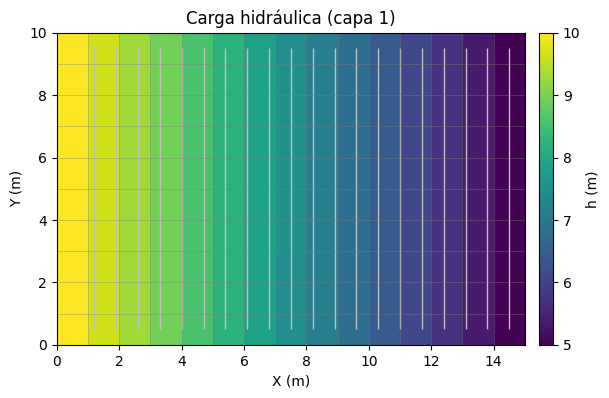

In [16]:
fig = plt.figure()
ax = fig.gca() # Ejes donde se hará la graficación

# Mapa visual del modelo. En este caso el modelo es 'o_gwf'.
mapview = flopy.plot.PlotMapView(model=o_gwf, ax=ax)

# Visualización de la carga hidráulica usando un mapa de color.
cb = mapview.plot_array(head, cmap="viridis", vmin=np.nanmin(head), vmax=np.nanmax(head))

# Visualización de la carga hidráulica usando contornos.
ct = mapview.contour_array(head, levels=20, linewidths=1.0, colors='silver')

# Visualización de la malla, con una transparencia.
mapview.plot_grid(linewidths=0.5, alpha =0.5)

# Barra de color.
plt.colorbar(cb, ax=ax, label="h (m)", cax = xmf6.vis.cax(ax, cb))

# Personalización de la gráfica.
ax.set_title("Carga hidráulica (capa 1)")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_aspect('equal')
plt.show()

### Recuperación de la descarga específica.

También es posible calcular y graficar la descarga específica, la cual se define como

$$
q = -K \nabla h
$$

Donde:
* $q$ : vector de descarga específica (flujo Darciano) [L/T].
* $K$ : conductividad hidráulica del medio [L/T].
* $\nabla h$: gradiente hidráulico (variación espacial de la carga hidráulica).

<div class="alert alert-block alert-info">

**Objetos, funciones y archivos a usar**.

* En este caso usaremos un objeto de la clase [`flopy.utils.CellBudgetFile`](https://flopy.readthedocs.io/en/3.3.2/source/flopy.utils.binaryfile.html#flopy.utils.binaryfile.CellBudgetFile).
* Luego para obtener los datos usamos la función `get_data()`. En este caso se requiere del parámetro `text = "DATA-SPDIS"` que indica que se obtendrá la descarga específica.
* Para que esto funcione, es necesario agregar el parámetro `save_specific_discharge = True` en el paquete NPF (*Node Property Flow*).
* La función `get_data` regresará una lista que contiene un solo elemento, el cual es un arreglo de tipo [`numpy.rec.recarray`](https://numpy.org/doc/stable/reference/generated/numpy.recarray.html).
  
</div>

In [17]:
# construimos el nombre con la ruta y extensión correcta
budfile = os.path.join(f"{sim_ws}", f"{sim_name}.bud")

# Objeto para obtener y manipular arreglos o series de tiempo de arreglos con datos
# de una o más celdas con información del archivo binario del budget.
bud  = flopy.utils.CellBudgetFile(budfile)

# Cargar resultados de la descarga específica
spdis = bud.get_data(text="DATA-SPDIS")[0]

# Imprimimos la información
print("spdis array:", spdis.shape)
xmf6.info_array(spdis)

spdis array: (150,)
 tipo  : <class 'numpy.rec.recarray'> 
 dtype : (numpy.record, [('node', '<i4'), ('node2', '<i4'), ('q', '<f8'), ('qx', '<f8'), ('qy', '<f8'), ('qz', '<f8')]) 
 dim   : 1 
 shape : (150,) 
 size(bytes) : 40 
 size(elements) : 150


<div class="alert alert-block alert-info">

**Observaciones**.

* El objeto `spdis` es de tipo `numpy.rec.recarray` con 6 columnas de información: `node`, `node2`, `q`, `qx`, `qy`, `qz`.
* Cada renglón de este arreglo corresponde a la información de una celda (en este caso $15 \times 10 =  150$ celdas).

| Columna | Descripción                             | Unidades |
| ------- | --------------------------------------- | -------- |
| `node`  | Índice del nodo origen: celda desde la que sale el flujo| —        |
| `node2` | Índice del nodo destino: celda hacia la que va el flujo | —        |
| `q`     | Caudal total entre `node` y `node2`     | m³/d     |
| `qx`    | Componente del flujo en dirección $x$ | m³/d     |
| `qy`    | Componente del flujo en dirección $y$ | m³/d     | 
| `qz`    | Componente del flujo en dirección $z$ (positivo hacia abajo)| m³/d     |

* Podemos ver el contenido de este arreglo como sigue:
</div>

In [18]:
print("\nSPDIS:\n", spdis)


SPDIS:
 [(  1,   1, 0., 0.35714286,  0.00000000e+00, 0.)
 (  2,   2, 0., 0.35714286,  5.47633050e-10, 0.)
 (  3,   3, 0., 0.35714286,  7.50866036e-12, 0.)
 (  4,   4, 0., 0.35714286, -1.00981623e-09, 0.)
 (  5,   5, 0., 0.35714286, -1.53560009e-09, 0.)
 (  6,   6, 0., 0.35714285, -8.93553675e-10, 0.)
 (  7,   7, 0., 0.35714285,  2.87018409e-09, 0.)
 (  8,   8, 0., 0.35714286,  1.05430837e-08, 0.)
 (  9,   9, 0., 0.35714286,  1.47557371e-08, 0.)
 ( 10,  10, 0., 0.35714286,  8.12601186e-09, 0.)
 ( 11,  11, 0., 0.35714286,  4.20858903e-10, 0.)
 ( 12,  12, 0., 0.35714286,  1.66894321e-09, 0.)
 ( 13,  13, 0., 0.35714285,  4.89590590e-09, 0.)
 ( 14,  14, 0., 0.35714284,  5.71419445e-09, 0.)
 ( 15,  15, 0., 0.35714284,  0.00000000e+00, 0.)
 ( 16,  16, 0., 0.35714286,  0.00000000e+00, 0.)
 ( 17,  17, 0., 0.35714286,  5.43539436e-10, 0.)
 ( 18,  18, 0., 0.35714286,  8.54491589e-10, 0.)
 ( 19,  19, 0., 0.35714286,  2.06802397e-09, 0.)
 ( 20,  20, 0., 0.35714286,  3.72881459e-09, 0.)
 ( 21,  21,

Podemos checar cada una de las columnas por separado:

In [19]:
print("\nnode:", spdis.node.shape)
xmf6.info_array(spdis.node)
print(spdis.node)

print("\nnode2:", spdis.node2.shape)
xmf6.info_array(spdis.node2)
print(spdis.node2)

print("\nq:", spdis.q.shape)
xmf6.info_array(spdis.q)
print(spdis.q)

print("\nqx:", spdis.qx.shape)
xmf6.info_array(spdis.qx)
print(spdis.qx)

print("\nqy:", spdis.qy.shape)
xmf6.info_array(spdis.qy)
print(spdis.qy)

print("\nqz:", spdis.qz.shape)
xmf6.info_array(spdis.qz)
print(spdis.qz)


node: (150,)
 tipo  : <class 'numpy.ndarray'> 
 dtype : int32 
 dim   : 1 
 shape : (150,) 
 size(bytes) : 4 
 size(elements) : 150
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150]

node2: (150,)
 tipo  : <class 'numpy.ndarray'> 
 dtype : int32 
 dim   : 1 
 shape : (150,) 
 size(bytes) : 4 
 size(elements) : 150
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  

In [20]:
# Extraemos las componentes del flujo en un arreglo 3D para graficación
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, o_gwf)

print("\nqx:", qx.shape)
xmf6.info_array(qx)
print(qx)

print("\nqy:", qy.shape)
xmf6.info_array(qy)
print(qy)


qx: (1, 10, 15)
 tipo  : <class 'numpy.ndarray'> 
 dtype : float64 
 dim   : 3 
 shape : (1, 10, 15) 
 size(bytes) : 8 
 size(elements) : 150
[[[0.35714286 0.35714286 0.35714286 0.35714286 0.35714286 0.35714285
   0.35714285 0.35714286 0.35714286 0.35714286 0.35714286 0.35714286
   0.35714285 0.35714284 0.35714284]
  [0.35714286 0.35714286 0.35714286 0.35714286 0.35714286 0.35714285
   0.35714285 0.35714285 0.35714286 0.35714287 0.35714286 0.35714286
   0.35714285 0.35714285 0.35714285]
  [0.35714286 0.35714286 0.35714286 0.35714286 0.35714286 0.35714286
   0.35714286 0.35714285 0.35714286 0.35714286 0.35714286 0.35714286
   0.35714285 0.35714285 0.35714286]
  [0.35714286 0.35714286 0.35714286 0.35714285 0.35714285 0.35714286
   0.35714286 0.35714286 0.35714285 0.35714286 0.35714286 0.35714286
   0.35714286 0.35714286 0.35714286]
  [0.35714285 0.35714285 0.35714286 0.35714286 0.35714286 0.35714286
   0.35714286 0.35714286 0.35714285 0.35714285 0.35714285 0.35714286
   0.35714286 0.357

In [21]:
# Coordenadas del centro de celdas para graficación
x, y, z = o_gwf.modelgrid.xyzcellcenters

print("\nx:", x.shape)
xmf6.info_array(x)
print(x)

print("\ny:", y.shape)
xmf6.info_array(y)
print(y)


x: (10, 15)
 tipo  : <class 'numpy.ndarray'> 
 dtype : float64 
 dim   : 2 
 shape : (10, 15) 
 size(bytes) : 8 
 size(elements) : 150
[[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5]]

y: (10, 15)
 tipo  : <class 'numpy.ndarray'> 
 dtype : float64

### Visualización de la descarga específica.

En este caso, se usan los mismos objetos que en la graficación de la carga hidráulica y solo se agregan los vectors de la descarga hidráulica.

<div class="alert alert-block alert-info">

**Observación**.

Para dibujar los vectores usamos la función `quiver()` de matplotlib, pues ya tenemos los arreglos `x`, `y`, `qx` y `qy` en el formato adecuado para graficarlos en 2D.

</div>

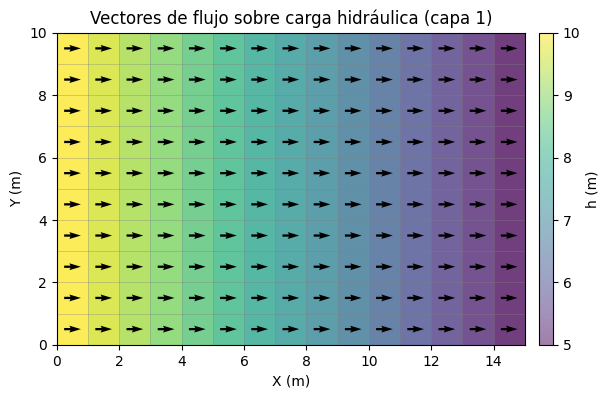

In [22]:
fig = plt.figure()
ax =fig.gca()
mapview = flopy.plot.PlotMapView(model=o_gwf, ax=ax)

# Visualización de la carga hidráulica usando un mapa de color.
cb = mapview.plot_array(head, cmap="viridis", alpha=0.5)

# Visualización de los vectores de la descarga específica.
ax.quiver(x, y, qx[0], qy[0], scale=10, color='k', pivot='middle')

# Visualización de la malla, con una transparencia.
mapview.plot_grid(linewidths=0.5, alpha =0.5)

# Barra de color.
plt.colorbar(cb, ax=ax, label="h (m)", cax = xmf6.vis.cax(ax, cb))

# Personalización de la gráfica.
ax.set_title("Vectores de flujo sobre carga hidráulica (capa 1)")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_aspect('equal')
plt.show()

# Referencias

[1] Langevin, C.D., Hughes, J.D., Provost, A.M., Banta, E.R., Niswonger, R.G., and Panday, Sorab, 2017, Documentation for the MODFLOW 6 Groundwater Flow (GWF) Model: U.S. Geological Survey Techniques and Methods, book 6, chap. A55, 197 p., accessed August 4, 2017. https://doi.org/10.3133/tm6A55.

[2] MODFLOW 6 – Description of Input and Output. Version mf6.4.4—February 13, 2024. U.S. Department of the Interior. U.S. Geological Survey.. Archivo: mf6io.pdf de la documentación de MODFLOW 6 que se puede obtener de https://github.com/MODFLOW-ORG/modflow6/releases.